In [2]:
# CIFAR-10 Image Reconstruction (Conv Autoencoder)
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

# Reproducibilit
torch.manual_seed(42)

batch_size = 128
lr = 1e-4
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.ToTensor()
train_data = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)

100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


In [17]:
class ConvAE(nn.Module):
  def __init__(self,latent_dim=512):
    super().__init__()
    self.enc = nn.Sequential(
       nn.Conv2d(3,32,3, stride=2, padding=1), nn.ReLU(inplace=True),
       nn.Conv2d(32,64,3, stride=2, padding=1), nn.ReLU(inplace=True),
       nn.Conv2d(64,128,3, stride=2, padding=1), nn.ReLU(inplace=True)
    )
    self.to_latent = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048,latent_dim), nn.ReLU(inplace=True)
    )
    self.from_latent = nn.Sequential(
        nn.Linear(latent_dim,2048),  nn.ReLU(inplace=True)
    )
    self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1), nn.Sigmoid()
    )
  def encode(self,x):
    h =self.enc(x)
    z= self.to_latent(h)
    return z , h.shape

  def decode(self,z,enc_shape):
      h = self.from_latent(z)
      h = h.view(-1,128,4,4)
      x = self.dec(h)
      return x
  def forward(self,x):
      z,enc_shape = self.encode(x)
      recon = self.decode(z,enc_shape)
      return recon

In [18]:
model = ConvAE().to(device)
opt = optim.Adam(model.parameters(),lr=lr)
criterion = nn.MSELoss()

In [19]:
for epoch in range(1,epochs+1):
    model.train()
    running = 0.0

    for imgs , _ in train_dataloader:
      imgs = imgs.to(device,non_blocking=True)
      opt.zero_grad()
      recon = model(imgs)
      loss = criterion(recon,imgs)
      loss.backward()
      opt.step()
      running += loss.item() * imgs.size(0)
    print(f"epochs : {epoch} | MSE: {running/len(train_dataloader.dataset):.6f}")

epochs : 1 | MSE: 0.037524
epochs : 2 | MSE: 0.022408
epochs : 3 | MSE: 0.019678
epochs : 4 | MSE: 0.018180
epochs : 5 | MSE: 0.017004
epochs : 6 | MSE: 0.016201
epochs : 7 | MSE: 0.015571
epochs : 8 | MSE: 0.014907
epochs : 9 | MSE: 0.013305
epochs : 10 | MSE: 0.012435


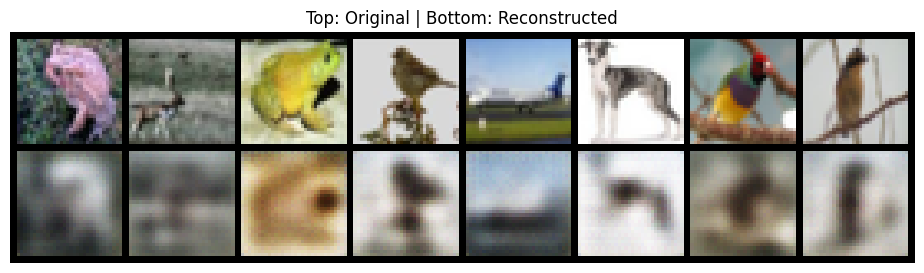

In [20]:
# Visualize reconstructions
model.eval()
imgs , _ =  next(iter(train_dataloader))
imgs = imgs.to(device)
with torch.no_grad():
  recon = model(imgs)
grid = utils.make_grid(torch.cat([imgs[:8], recon[:8]], dim=0), nrow=8)
plt.figure(figsize=(12,3))
plt.imshow(grid.permute(1,2,0).cpu().numpy())
plt.axis("off")
plt.title("Top: Original | Bottom: Reconstructed")
plt.show()